In [52]:
import os
import csv
from collections import deque
import itertools
import time

import librosa

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

#Keras
import keras
from keras import models
from keras import layers
from keras.callbacks import Callback

%matplotlib inline

In [2]:
#trainpath = '../data/kaggle-train-small/audio/'
trainpath = '../data/kaggle-train/audio/'
testpath = '../data/kaggle-test/audio/'

In [3]:
df_train = pd.read_pickle('./df_train.pkl')
df_train.head(20)

,filename,audiotype,instrument,chroma_stft_mean,chroma_stft_std,rmse_mean,rmse_std,spec_cent_mean,spec_cent_std,spec_bw_mean,...,mfcc_mean15,mfcc_std15,mfcc_mean16,mfcc_std16,mfcc_mean17,mfcc_std17,mfcc_mean18,mfcc_std18,mfcc_mean19,mfcc_std19
0,keyboard_acoustic_010-064-050.wav,acoustic,keyboard,0.141385,0.289322,0.061293,0.088629,732.297437,911.230067,663.857505,...,-7.161865,5.648172,-7.185595,8.262616,-4.402485,8.154543,3.564694,5.718117,15.429117,7.454765
1,organ_electronic_048-084-127.wav,electronic,organ,0.153087,0.302638,0.269546,0.152640,2285.527728,1254.141576,855.624158,...,-2.765366,3.358678,-7.692285,6.340927,-12.007803,7.286099,-11.306641,6.808135,32.281609,18.238966
2,bass_synthetic_038-093-050.wav,synthetic,bass,0.187979,0.264302,0.008968,0.027033,2363.676030,1054.728094,2259.705737,...,9.904331,5.561808,3.634877,3.355129,-4.532478,4.726028,26.104923,15.218951,-13.752032,9.753820
3,brass_acoustic_014-067-100.wav,acoustic,brass,0.228951,0.305377,0.082316,0.048830,2186.983600,778.104957,1570.445255,...,-6.686733,5.794637,33.675407,15.761654,34.699574,14.006486,42.621082,18.076965,18.158424,7.996955
4,bass_synthetic_123-070-075.wav,synthetic,bass,0.031193,0.148407,0.013941,0.069042,308.126005,883.964268,245.251431,...,2.408881,7.501947,1.651202,4.916420,0.563238,2.538653,0.019563,1.103113,-0.736997,2.378023
5,organ_electronic_065-061-050.wav,electronic,organ,0.116215,0.269425,0.320845,0.201841,387.462269,582.655839,437.770765,...,0.659330,4.413772,3.569622,5.520141,-11.473527,6.826658,-10.947213,7.071216,1.169024,3.583707
6,guitar_acoustic_011-079-025.wav,acoustic,guitar,0.100189,0.251751,0.009332,0.029059,1590.736313,1355.110149,1144.079292,...,2.290287,4.052349,2.318639,3.328717,6.368520,5.995106,12.453623,15.721991,4.995918,8.226757
7,string_acoustic_010-040-127.wav,acoustic,string,0.220066,0.308069,0.015233,0.044543,471.090225,598.985427,788.198427,...,-3.003569,3.476644,-2.097698,2.789591,-1.758090,3.238113,-1.397056,2.802639,-1.792941,3.074017
8,keyboard_electronic_004-074-025.wav,electronic,keyboard,0.050198,0.193557,0.029618,0.090987,277.892332,384.914199,204.552443,...,-2.336124,3.447099,-5.185911,7.627150,-6.430520,9.426462,-5.752944,8.435960,-3.430038,5.121261
9,mallet_acoustic_075-084-025.wav,acoustic,mallet,0.346899,0.325698,0.023630,0.052565,1143.625495,198.873128,1623.155313,...,4.408544,5.452908,5.958602,7.441835,4.998078,4.751276,0.980078,2.564556,2.709939,6.365163


In [25]:
traindata = df_train[[c for c in df_train.columns if c not in ['filename', 'audiotype']]]

In [26]:
# normalizing
scaler = StandardScaler()
X = scaler.fit_transform(np.array(traindata.iloc[:,1:], dtype = float))
print(X.shape)
print(X[0])

(269776, 52)
[-0.43282585  0.21044656 -0.60180856 -0.19662271 -0.35474175  0.5491243
 -0.2429523   0.9712936  -0.38455103  0.98335249 -0.32061836  0.18596393
 -0.26692576 -0.77711603 -0.11110348  0.35818454  0.68047229 -0.44001309
 -0.1844341  -0.6764978   0.31683199 -0.44001361 -0.0575284  -0.81213866
  0.00129278 -0.85820828 -0.48904938 -0.92589354 -0.55287598 -0.48359531
 -1.00704589 -0.23179344 -1.08202351 -0.12493322 -0.82851176 -0.2288695
 -0.95016844 -0.30094444 -0.66864483 -0.50868495 -0.71498318 -0.59786263
 -0.49599124 -0.10645992 -0.73605492  0.68370968 -0.31786875  0.54757835
  0.33145075 -0.180274    1.16661129  0.1495536 ]


In [27]:
# defining target
encoder = LabelEncoder()
y = encoder.fit_transform(traindata['instrument'])
print(y.shape)
print(y[0:5])

(269776,)
[4 6 0 1 0]


In [60]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(kind='regular')
Xbal, ybal = smote.fit_sample(X, y)
print(X.shape)
print(y.shape)
print(Xbal.shape)
print(ybal.shape)

(269776, 52)
(269776,)
(652740, 52)
(652740,)


In [63]:
# spliting of dataset into train and test dataset
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

skf = StratifiedKFold(n_splits=2)
for train_index, test_index in skf.split(Xbal, ybal):
    X_train, X_test = Xbal[train_index], Xbal[test_index]
    y_train, y_test = ybal[train_index], ybal[test_index]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(326370, 52)
(326370,)
(326370, 52)
(326370,)


In [8]:
#https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def clf_eval(y_pred, y_true, classes=encoder.inverse_transform(range(10))):
    clf_matrix = confusion_matrix(y_true, y_pred)
    print('Classification Report')
    print(classification_report(y_true, y_pred, target_names=classes))
    #print('ROC Score: {}'.format(roc_auc_score(y_true, y_pred)))
    print('Accuracy Score: {}'.format(accuracy_score(y_true, y_pred)))
    #print('Average Precision Score: {}'.format(average_precision_score(y_true, y_pred)))
    print('f1 Score: {}'.format(f1_score(y_true, y_pred, average='micro')))
    plot_confusion_matrix(clf_matrix, classes=classes)
    return #roc_auc_score(y_true, y_pred)

#https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2

class Metrics(Callback):
    
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        self.aucs = []
        self.losses = []

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return
        
    def on_epoch_end(self, epoch, logs={}):
        val_predict = np.argmax(np.asarray(self.model.predict(self.validation_data[0])), axis=1).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict, average='micro')
        _val_recall = recall_score(val_targ, val_predict, average='micro')
        _val_precision = precision_score(val_targ, val_predict, average='micro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        self.losses.append(logs.get('loss'))
        y_pred = self.model.predict(self.validation_data[0])
        #self.aucs.append(roc_auc_score(self.validation_data[1], y_pred))
        print('— val_f1: {} — val_precision: {} — val_recall {}'.format(_val_f1, _val_precision, _val_recall))
        return
    
    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return
 
metrics = Metrics()

#### Logistic Regression

Classification Report
              precision    recall  f1-score   support

        bass       0.49      0.62      0.55     65274
       brass       0.62      0.48      0.54     12605
       flute       0.58      0.30      0.40      8738
      guitar       0.41      0.11      0.17     27415
    keyboard       0.43      0.50      0.46     51821
      mallet       0.49      0.56      0.52     26857
       organ       0.72      0.79      0.76     34301
        reed       0.61      0.48      0.53     13307
      string       0.63      0.70      0.66     19390
       vocal       0.67      0.41      0.51     10068

    accuracy                           0.54    269776
   macro avg       0.57      0.50      0.51    269776
weighted avg       0.53      0.54      0.52    269776

Accuracy Score: 0.5353181899056996
f1 Score: 0.5353181899056996
Confusion matrix, without normalization
[[40707   676   362  1203 10006  5320  4160   898  1222   720]
 [ 1839  6104   274   322  2283    15   153   556  1

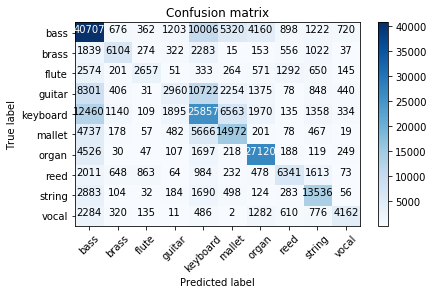

In [37]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            dual=False, 
                            tol=0.001, 
                            C=0.10, 
                            fit_intercept=True, 
                            intercept_scaling=1, 
                            class_weight=None, 
                            random_state=0, 
                            solver='saga', 
                            max_iter=100, 
                            multi_class='ovr', 
                            verbose=0, 
                            warm_start=False, 
                            n_jobs=-1).fit(X_train, y_train)

yhat = clf_lr.predict(X_test)
clf_eval(yhat, y_test)

#### Ridge

Classification Report
              precision    recall  f1-score   support

        bass       0.45      0.67      0.54     65274
       brass       0.72      0.31      0.43     12605
       flute       0.70      0.07      0.13      8738
      guitar       0.38      0.04      0.08     27415
    keyboard       0.40      0.53      0.45     51821
      mallet       0.49      0.42      0.45     26857
       organ       0.61      0.78      0.68     34301
        reed       0.67      0.28      0.40     13307
      string       0.59      0.58      0.58     19390
       vocal       0.84      0.20      0.33     10068

    accuracy                           0.49    269776
   macro avg       0.58      0.39      0.41    269776
weighted avg       0.51      0.49      0.46    269776

Accuracy Score: 0.48982489176205446
f1 Score: 0.48982489176205446
Confusion matrix, without normalization
[[43842   261    28   299 10171  4128  5747    85   646    67]
 [ 2755  3905    26   311  3019   154   355   482 

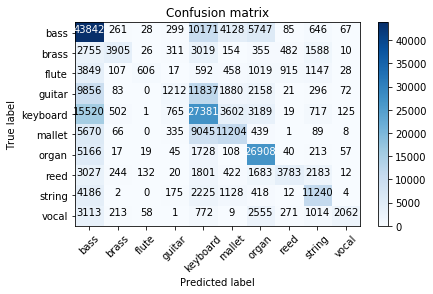

In [38]:
#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html
from sklearn.linear_model import RidgeClassifier

clf_rdg = RidgeClassifier(alpha=1.0, 
                          fit_intercept=True, 
                          normalize=False, 
                          copy_X=True, 
                          max_iter=None, 
                          tol=0.001, 
                          class_weight=None, 
                          solver='auto', 
                          random_state=0).fit(X_train, y_train)

yhat = clf_rdg.predict(X_test)
clf_eval(yhat, y_test)

#### Random Forests

Classification Report
              precision    recall  f1-score   support

        bass       0.98      0.90      0.94     32637
       brass       0.99      1.00      1.00     32637
       flute       0.99      1.00      0.99     32637
      guitar       0.96      0.97      0.96     32637
    keyboard       0.94      0.93      0.93     32637
      mallet       0.94      0.99      0.96     32637
       organ       0.98      0.99      0.99     32637
        reed       0.99      1.00      0.99     32637
      string       0.99      1.00      0.99     32637
       vocal       1.00      1.00      1.00     32637

    accuracy                           0.98    326370
   macro avg       0.98      0.98      0.98    326370
weighted avg       0.98      0.98      0.98    326370

Accuracy Score: 0.9762815209731287
f1 Score: 0.9762815209731287
Confusion matrix, without normalization
[[29246    35    93   709  1302   692   284   104    84    88]
 [    0 32598    12     2     0     0     0     3   

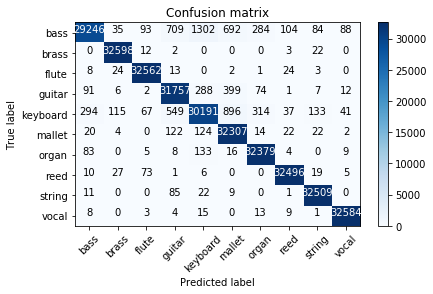

In [64]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=300, 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=10, #2,
                                min_samples_leaf=10, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=0, 
                                verbose=0, 
                                warm_start=False, 
                                class_weight='balanced').fit(X_train, y_train)



yhat = clf_rf.predict(X_test)
clf_eval(yhat, y_test)

#### Adaboost Classifier

Classification Report
              precision    recall  f1-score   support

        bass       0.47      0.50      0.49     65274
       brass       0.52      0.33      0.41     12605
       flute       0.45      0.10      0.16      8738
      guitar       0.35      0.03      0.05     27415
    keyboard       0.34      0.60      0.43     51821
      mallet       0.33      0.38      0.35     26857
       organ       0.67      0.59      0.63     34301
        reed       0.37      0.40      0.39     13307
      string       0.69      0.43      0.53     19390
       vocal       0.37      0.34      0.35     10068

    accuracy                           0.43    269776
   macro avg       0.46      0.37      0.38    269776
weighted avg       0.45      0.43      0.42    269776

Accuracy Score: 0.43355598718937194
f1 Score: 0.43355598718937194
Confusion matrix, without normalization
[[32954   514   241   247 16837  8100  2915   739   567  2160]
 [  805  4211    26   143  4401     1   719  1565 

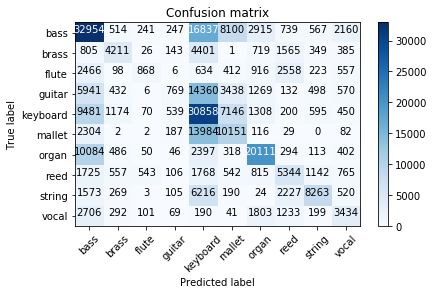

In [40]:
#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
from sklearn.ensemble import AdaBoostClassifier

clf_abc = AdaBoostClassifier(base_estimator=None,
                             n_estimators=300,
                             learning_rate=0.1,
                             algorithm='SAMME.R',
                             random_state=0).fit(X_train, y_train)

yhat = clf_abc.predict(X_test)
clf_eval(yhat, y_test)

#### Gradient Boost Classifier

In [50]:
#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
from sklearn.ensemble import GradientBoostingClassifier

clf_gbc = GradientBoostingClassifier(loss='deviance',
                                     learning_rate=0.1,
                                     n_estimators=200,
                                     subsample=1.0, 
                                     min_samples_split=3, 
                                     min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, 
                                     max_depth=3, 
                                     init=None, 
                                     random_state=0, 
                                     max_features=None, 
                                     verbose=0, 
                                     max_leaf_nodes=None, 
                                     warm_start=False, 
                                     presort='auto').fit(X_train, y_train)

yhat = clf_gbc.predict(X_test)
clf_eval(yhat, y_test)

KeyboardInterrupt: 

#### XGBoost classifier

In [ ]:
import xgboost

clf_xgb = xgboost.sklearn.XGBClassifier(base_score=0.5,
                                        learning_rate=0.1,
                                        n_estimators=250,
                                        max_delta_step=0,
                                        max_depth=2,
                                        min_child_weight=1,
                                        missing=None,
                                        gamma=0.1,
                                        subsample=1,
                                        colsample_bylevel=1,
                                        colsample_bytree=1,
                                        objective= 'binary:logitraw',
                                        #objective='multi:softprob',
                                        reg_alpha=0, 
                                        reg_lambda=1,
                                        nthread=-1,
                                        scale_pos_weight=1,
                                        seed=0,
                                        silent=False,
                                        random_state=0).fit(X_train, y_train)

yhat = clf_xgb.predict(X_test)
clf_eval(yhat, y_test)

#### Regularized Greedy Forest

Classification Report
              precision    recall  f1-score   support

        bass       0.57      0.73      0.64     19638
       brass       0.76      0.59      0.67      3748
       flute       0.65      0.26      0.37      2634
      guitar       0.59      0.25      0.35      8209
    keyboard       0.55      0.66      0.60     15436
      mallet       0.59      0.58      0.58      8095
       organ       0.76      0.79      0.77     10383
        reed       0.74      0.49      0.59      4021
      string       0.73      0.79      0.76      5773
       vocal       0.76      0.53      0.63      2996

    accuracy                           0.62     80933
   macro avg       0.67      0.57      0.60     80933
weighted avg       0.63      0.62      0.61     80933

Accuracy Score: 0.6242447456538124
f1 Score: 0.6242447456538124
Confusion matrix, without normalization
[[14288    35    41   492  2446  1157   880    53   165    81]
 [  259  2226    42    77   519    49   109   114   

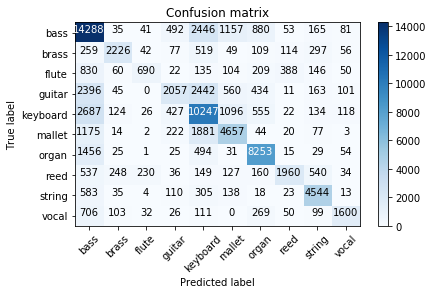

In [49]:
from rgf.sklearn import RGFClassifier, FastRGFClassifier

clf_rgf = RGFClassifier(max_leaf=240,
                        algorithm="RGF_Sib",
                        test_interval=100,
                        verbose=False,).fit(X_train, y_train)

yhat = clf_rgf.predict(X_test)
clf_eval(yhat, y_test)

#### Keras and Tensor Flow

Train on 326370 samples, validate on 326370 samples
Epoch 1/20
326370/326370 [==============================] - 14s 44us/step - loss: 1.0336 - acc: 0.6333 - val_loss: 0.6554 - val_acc: 0.7621
— val_f1: 0.7620829120323559 — val_precision: 0.7620829120323559 — val_recall 0.7620829120323559
Epoch 2/20
326370/326370 [==============================] - 12s 38us/step - loss: 0.7555 - acc: 0.7291 - val_loss: 0.5254 - val_acc: 0.8116
— val_f1: 0.8116064589269847 — val_precision: 0.8116064589269847 — val_recall 0.8116064589269847
Epoch 3/20
326370/326370 [==============================] - 13s 40us/step - loss: 0.6520 - acc: 0.7655 - val_loss: 0.4545 - val_acc: 0.8371
— val_f1: 0.837095934062567 — val_precision: 0.837095934062567 — val_recall 0.837095934062567
Epoch 4/20
326370/326370 [==============================] - 13s 39us/step - loss: 0.5870 - acc: 0.7893 - val_loss: 0.3956 - val_acc: 0.8602
— val_f1: 0.8602353157459325 — val_precision: 0.8602353157459325 — val_recall 0.8602353157459325
Epo

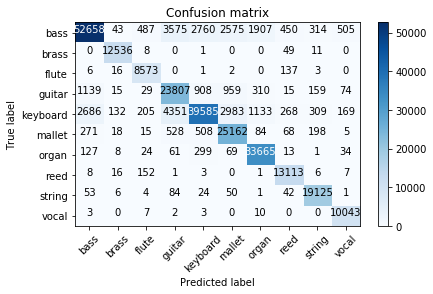

In [73]:
# creating a model
model = models.Sequential()
model.add(layers.Dense(256, activation='selu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='selu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='selu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
              
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test,y_test),
                    #validation_split=0.2,
                    epochs=20,
                    batch_size=64,
                    callbacks=[metrics]
                   )
                    
# calculate accuracy
test_loss, test_acc = model.evaluate(X_test,y_test)
print('test_acc: ',test_acc)

# predictions
yhat = np.argmax(model.predict(X), axis=1)
clf_eval(yhat, y)

In [12]:
print(yhat.shape)
print(y.shape)
print(yhat[0:20])
print(y[0:20])

(269776,)
(269776,)
[4 6 0 1 0 6 3 8 4 5 0 1 5 8 4 4 0 9 5 0]
[4 6 0 1 0 6 3 8 4 5 0 1 5 8 4 4 0 9 5 0]


In [15]:
files = os.listdir(testpath)
df_test = pd.DataFrame(files, columns=['id'])
df_test['id'] = df_test['id'].str.extract(pat = '([0-9]*).wav')
df_test['id'] = pd.to_numeric(df_test['id'])
df_test['chroma_stft_mean'] = np.mean(stft, axis=(1,2))
df_test['chroma_stft_std'] = np.std(stft, axis=(1,2))
df_test['rmse_mean'] = np.mean(rmse, axis=(1,2))
df_test['rmse_std'] = np.std(rmse, axis=(1,2))
df_test['spec_cent_mean'] = np.mean(spec_cent, axis=(1,2))
df_test['spec_cent_std'] = np.std(spec_cent, axis=(1,2))
df_test['spec_bw_mean'] = np.mean(spec_bw, axis=(1,2))
df_test['spec_bw_std'] = np.std(spec_bw, axis=(1,2))
df_test['rolloff_mean'] = np.mean(rolloff, axis=(1,2))
df_test['rolloff_std'] = np.std(rolloff, axis=(1,2))
df_test['zcr_mean'] = np.mean(zcr, axis=(1,2))
df_test['zcr_std'] = np.std(zcr, axis=(1,2))
for j in range(0, 20):
    df_test[f' mfcc_mean{j}'] = np.mean(mfcc[:,j,:], axis=1)
    df_test[f' mfcc_std{j}'] = np.std(mfcc[:,j,:], axis=1)
    
df_test.sort_values(by='id', inplace=True)
df_test.head()

df_test.to_pickle('./df_test.pkl')

In [16]:
df_test = pd.read_pickle('./df_test.pkl')
df_test.head(20)

,id,chroma_stft_mean,chroma_stft_std,rmse_mean,rmse_std,spec_cent_mean,spec_cent_std,spec_bw_mean,spec_bw_std,rolloff_mean,...,mfcc_mean15,mfcc_std15,mfcc_mean16,mfcc_std16,mfcc_mean17,mfcc_std17,mfcc_mean18,mfcc_std18,mfcc_mean19,mfcc_std19
622,0,0.134269,0.277814,0.014995,0.053736,778.699022,1250.449434,597.182767,866.517543,1380.240979,...,0.676732,3.559924,0.898353,3.097811,0.056652,2.810290,-2.215599,4.612552,-2.075452,4.742674
2553,1,0.260542,0.337406,0.016345,0.048726,787.418802,368.781377,1043.350929,279.771544,1438.617120,...,0.335795,3.331947,-5.045141,6.385585,3.743817,3.509501,13.255790,8.850987,1.255885,3.209254
2701,2,0.780810,0.131327,0.193366,0.057617,3257.143238,40.831209,1859.838776,25.071794,5358.157966,...,-19.051245,3.559989,17.527319,3.522346,-13.264457,3.076792,9.172668,3.257355,-4.606864,3.240846
1976,3,0.087238,0.249132,0.052245,0.107264,2473.820923,1337.052591,943.448108,540.123563,2780.085887,...,2.291314,1.789674,11.180297,7.114735,-2.630100,2.376085,-4.014489,4.711635,17.793020,13.390434
327,4,0.110868,0.258706,0.188245,0.129229,988.891795,519.377966,1144.712083,582.032026,2181.388158,...,-5.929082,5.237872,1.762167,4.297822,-6.312331,4.667293,1.252282,3.325254,0.219246,3.723259
638,5,0.239240,0.333997,0.062295,0.084720,945.399323,846.434540,988.391574,775.412853,1722.594015,...,-5.973209,11.387267,1.432321,7.950373,11.578344,7.194522,22.075968,12.761677,31.051577,20.094412
4069,6,0.201913,0.322992,0.019195,0.032339,644.723028,829.214567,755.973199,594.808380,998.617854,...,-11.352953,7.940487,-10.532652,7.747516,-10.004939,7.220841,-9.652685,5.750502,-6.099499,5.076620
3172,7,0.102322,0.260507,0.020350,0.050722,837.315360,714.605196,823.078905,698.697446,1271.268035,...,-4.434813,9.722361,-8.599571,10.066700,-9.281170,7.087295,-6.881221,7.280783,-8.026646,6.520137
1972,8,0.143575,0.276178,0.447729,0.201957,1541.533348,127.295218,1615.239590,137.007528,3054.416405,...,35.275311,4.178177,79.012222,13.515082,78.596977,10.467761,42.524578,6.747061,-10.382318,5.078318
2172,9,0.034328,0.156212,0.004211,0.029150,267.880008,869.141259,152.965141,534.418245,440.497144,...,-0.152445,1.757892,0.469250,2.033746,0.030877,0.781755,-0.309019,2.470962,0.411489,1.867815


In [17]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4096 entries, 622 to 955
Data columns (total 53 columns):
id                  4096 non-null int64
chroma_stft_mean    4096 non-null float32
chroma_stft_std     4096 non-null float32
rmse_mean           4096 non-null float32
rmse_std            4096 non-null float32
spec_cent_mean      4096 non-null float64
spec_cent_std       4096 non-null float64
spec_bw_mean        4096 non-null float64
spec_bw_std         4096 non-null float64
rolloff_mean        4096 non-null float64
rolloff_std         4096 non-null float64
zcr_mean            4096 non-null float64
zcr_std             4096 non-null float64
 mfcc_mean0         4096 non-null float32
 mfcc_std0          4096 non-null float32
 mfcc_mean1         4096 non-null float32
 mfcc_std1          4096 non-null float32
 mfcc_mean2         4096 non-null float32
 mfcc_std2          4096 non-null float32
 mfcc_mean3         4096 non-null float32
 mfcc_std3          4096 non-null float32
 mfcc_mean4 

In [19]:
testdata = df_test[[c for c in df_test.columns if c not in ['id']]]
Xpred = scaler.fit_transform(np.array(testdata, dtype = float))
print(Xpred.shape)
print(Xpred[0])

(4096, 52)
[-0.58930917 -0.03538164 -1.05934711 -0.93565379 -0.23418175  1.5497451
 -0.34618488  1.66927244 -0.16031142  1.71236387 -0.11446266  1.27206017
 -0.6834673  -0.93013896 -0.82327378  0.07217647  0.124498   -0.16501357
 -0.50116211  0.00268468  0.1737783   0.18955774 -0.13492047  0.8273721
  0.43181115  0.31582152 -0.09522162 -0.59223709  0.0911381  -0.81396165
  0.0792813  -1.06920335  0.29253238  0.00393513  0.31530798 -0.63111726
 -0.21526263 -0.74239987  0.03090668 -0.43486584 -0.10676291 -0.76380859
  0.29554985 -0.67103755  0.01827597 -0.72443786  0.11773691 -0.84249392
 -0.1409263  -0.38127821 -0.11868424 -0.34455231]


In [74]:
familyPredictions = np.argmax(model.predict(Xpred), axis=1)
#familyPredictions = clf_rf.predict(Xpred)
familyPredictionStrings = encoder.inverse_transform(familyPredictions)
print(familyPredictions.shape)
print(familyPredictions[0:10])
print(familyPredictionStrings)

(4096,)
[0 4 0 0 9 4 4 3 0 4]
['bass' 'keyboard' 'bass' ... 'string' 'bass' 'keyboard']


In [75]:
with open('renato-submission.csv', 'w', newline='') as writeFile:
    fieldnames = ['Id', 'Predicted']
    writer = csv.DictWriter(writeFile, fieldnames=fieldnames, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writeheader()
    for index in range(len(testdata)):
        writer.writerow({'Id': index, 'Predicted': familyPredictionStrings[index]})